# SMOTE (Synthetic Minority Oversampling Technique) for data generation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import imblearn
import scipy
import scipy.stats as stats
from scipy.stats.stats import pearsonr
import time
import sys
sys.path.insert(1, '../../')

## 1. Loading Data

In [2]:
%%sh
ls -laFh ../../data/statistical-generative-modeling-sample.csv.bz2

-rw-r--r-- 1 auriane auriane 4,4M juil.  7 14:58 ../../data/statistical-generative-modeling-sample.csv.bz2


In [3]:
df = pd.read_csv("../../data/statistical-generative-modeling-sample.csv.bz2")

In [4]:
df

,SEATS,PASSENGERS,FREIGHT,DISTANCE,RAMP_TO_RAMP,AIR_TIME,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,AIRCRAFT_TYPE,MONTH,Unnamed: 14
0,0.0,0.0,331088.0,216.0,1708.0,780.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12402,ITO,620,6,NaN
1,0.0,0.0,1081490.0,163.0,5695.0,1782.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12758,KOA,620,6,NaN
2,0.0,0.0,570900.0,102.0,2006.0,884.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,12982,LIH,620,6,NaN
3,0.0,0.0,1206131.0,100.0,6146.0,1704.0,1TQ,Rhoades Aviation dba Transair,12173,HNL,13830,OGG,620,6,NaN
4,0.0,0.0,180778.0,216.0,2135.0,1092.0,1TQ,Rhoades Aviation dba Transair,12402,ITO,12173,HNL,620,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394121,105984.0,81424.0,511764.0,100.0,34737.0,17951.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,3,NaN
394122,106368.0,74321.0,143112.0,100.0,33693.0,19865.0,HA,Hawaiian Airlines Inc.,13830,OGG,12173,HNL,608,10,NaN
394123,106752.0,71430.0,600636.0,100.0,35319.0,18013.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,10,NaN
394124,107904.0,77703.0,478682.0,100.0,34822.0,18338.0,HA,Hawaiian Airlines Inc.,12173,HNL,13830,OGG,608,5,NaN


In [5]:
reduced_size = 500

In [6]:
df_sample = df[["DISTANCE", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]][:reduced_size]

In [7]:
df_sample

,DISTANCE,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID
0,216.0,12173,12402
1,163.0,12173,12758
2,102.0,12173,12982
3,100.0,12173,13830
4,216.0,12402,12173
...,...,...,...
495,122.0,10551,14282
496,145.0,10551,14718
497,38.0,10551,15257
498,117.0,10551,15282


## 2. Useful functions

In [8]:
from tools import gauss_truncated

In [9]:
from common_structure import remove_ticks, remove_splines, modify_splines

In [10]:
def computes_KNN(elem, target_list, k):
    
    """
    Computes k nearest neighbors of an element
    :param elem: numpy array of the element we consider
    :param target_list: numpy array of elements from which we will compute the neighbors
    :param k: int, number of neighbors in KNN
    :return: list of k nearest neighbors
    """
    
     # list of neighours: associated length and indexes
    distances_neighbors = []
    for i in range (len(target_list)):
        distances_neighbors.append([np.linalg.norm(target_list[i] - elem),  i])
    distances_neighbors = sorted(distances_neighbors, key=lambda x: x[0])
    
    # we keep the k neighbors with smallest length
    closets_distances_neighbors = distances_neighbors[:k]
    
    # we compute the neighbors according to the indexes
    nearest_neighbors = []
    for i in range(k):
        nearest_neighbors.append(target_list[closets_distances_neighbors[i][1]])
        
    return nearest_neighbors

In [11]:
def standardize_data(X):
    
    """
    Returns reduced and centered data
    :param X: numpy array of initial data
    return: numpy array where columns have been standardized (zero mean and unit standard deviation)
    """
    
    X2 = X.copy()
    for j in range(len(X2[0])):
        X2[:,j] = X2[:,j] - np.mean(X2[:,j])
        X2[:,j] = X2[:,j] / (np.std(X2[:,j]) + 1*10**-16)
        
    return X2

In [12]:
def destandardize_data(X, mean, std):
    
    """
    Destandardizes reduced and centered data
    :param X: array of initial reduced and centered data
    :param mean: float, wanted mean
    :param std: float, wanted standard deviation
    :return: numpy array where columns have been destandardized (have wanted mean and standard deviation)
    """
    
    X2 = X.copy()
    for j in range(len(X2[0])):
        X2[:,j] = X2[:,j] * std[j]
        X2[:,j] = X2[:,j] + mean[j]
       
    return X2

## 3. Data pre-processing

In [13]:
from data_processing import categorical_to_numerical

In [14]:
categorical_fields = ["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"]

In [15]:
df_sample_num, transitional_dfs = categorical_to_numerical(df_sample, categorical_fields)

In [16]:
df_sample_num

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,216.0,0.418518,0.487865
1,163.0,0.420846,0.503838
2,102.0,0.418402,0.530189
3,100.0,0.414245,0.441607
4,216.0,0.537335,0.249410
...,...,...,...
495,122.0,0.244850,0.921267
496,145.0,0.271908,0.995002
497,38.0,0.249628,0.896387
498,117.0,0.251654,0.768581


## 4.    Modeling and generation

In [17]:
from common_structure import Model, Distribution

### Explanation of SMOTE technique for generation

We now apply a new generative technique based on SMOTE (Synthetic Minority Oversampling Technique). The idea is that each data row is represented as an n-dimensional vector. We compute its k-nearest neighbors and select one randomly. We then create a new point using the formula:

$$x_{new} = x_{init} + \gamma (x_{rand} - x_{init})$$

Where $x_{init}$ is the initial point, $x_{rand}$ is the random point selected among the k nearest neighbors, and $\gamma$ is a random number selected between $0$ and $1$.

In [23]:
print(520%100)

20


In [135]:
class smote_model(Model):
    
    """
    Implements smote technique 
    """
    
    def generate_data(self, k, n, visualization_2D = False):
        
        """
        Generates new data using smote
        :param k: int, number of neighbors that will be used for KNN
        :param n: int, number of elements that will be generated
        """
       
        print(n%self.df.shape[0])
        print(n)
        print(self.df.shape[0])
        
        if visualization_2D:
            fig, ax = plt.subplots()
            fig.canvas.draw()
            
        # new empty data-frame for generated data
        #self.df_gen = np.zeros(self.df.shape)
        self.df_gen = np.zeros((n, self.df.shape[1]))
    
        # standardizing data
        self.df_norm = standardize_data(self.df.to_numpy())
        self.df_norm = pd.DataFrame(self.df_norm)
        
        c=0
        for i in range(n//self.df.shape[0] + self.df.shape[0]):
            
            # going through each row
            for index, row in self.df_norm.iterrows():
                if c<n:
                    row = row.to_numpy()
                    target_rows = np.delete(self.df_norm.to_numpy(), index, axis=0)

                    # computing k nearest neighbors
                    neigh = computes_KNN(row, target_rows, k)

                    # selecting randomly one of them
                    rand = np.random.randint(k-1)
                    selected_neigh = neigh[rand]

                    # creating new point between initial point and selected neighbor
                    new_point = row + np.random.rand(1)[0] *(selected_neigh - row)
                    self.df_gen[index] = new_point
                    c += 1

                    if visualization_2D:
                        stop_time = 1
                        plt.ion()
                        ax.clear()
                        ax.scatter(target_rows[:,0], target_rows[:,1], label="Initial data")
                        ax.scatter(row[0], row[1], c="r", label = "Considered element")
                        time.sleep(stop_time)
                        fig.canvas.draw()
                        ax.scatter(np.array(neigh)[:,0], np.array(neigh)[:,1], c = "cyan", label = "Neighbors")
                        time.sleep(stop_time)
                        fig.canvas.draw()
                        ax.scatter(new_point[0], new_point[1], c="y", label = "New point")
                        time.sleep(stop_time)
                        fig.canvas.draw()
                        fig.legend()
                        
        if visualization_2D:
            plt.ioff()
            plt.close()
                

        
       
        

            
        self.df_gen = destandardize_data(self.df_gen, self.df.mean(), self.df.std())
        self.df_gen = pd.DataFrame(data = self.df_gen, columns = self.df.columns)
        
        return self.df_gen
        
        


In [136]:
Mod_vis = smote_model(df_sample_num[df_sample_num.columns[:2]][:10])

2
12
10


<IPython.core.display.Javascript object>


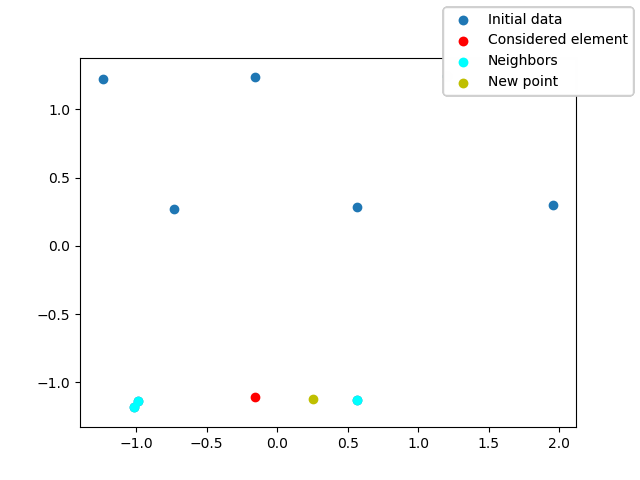

In [139]:
gen_vis = Mod_vis.generate_data(3, 12, visualization_2D = True)

In [122]:
Mod = smote_model(df_sample_num)

New data generation:

In [127]:
# number of neighbors
k=5

In [130]:
df_gen = Mod.generate_data(k, 22)

22
22
500


In [131]:
df_gen

,DISTANCE,ORIGIN_AIRPORT_ID_NUM,DEST_AIRPORT_ID_NUM
0,190.309302,0.417936,0.496150
1,140.062572,0.419873,0.513485
2,107.407039,0.418564,0.527591
3,105.962377,0.414498,0.448271
4,215.436767,0.537892,0.248717
5,248.810643,0.530516,0.517486
6,120.341624,0.524810,0.469088
7,141.689016,0.638216,0.248074
8,231.401712,0.648034,0.489598
9,73.473373,0.618660,0.469200


## 5. Quality assessment

In [61]:
from data_viz import Closeness

In [63]:
res = closeness(df_sample_num, df_gen)

<IPython.core.display.Javascript object>


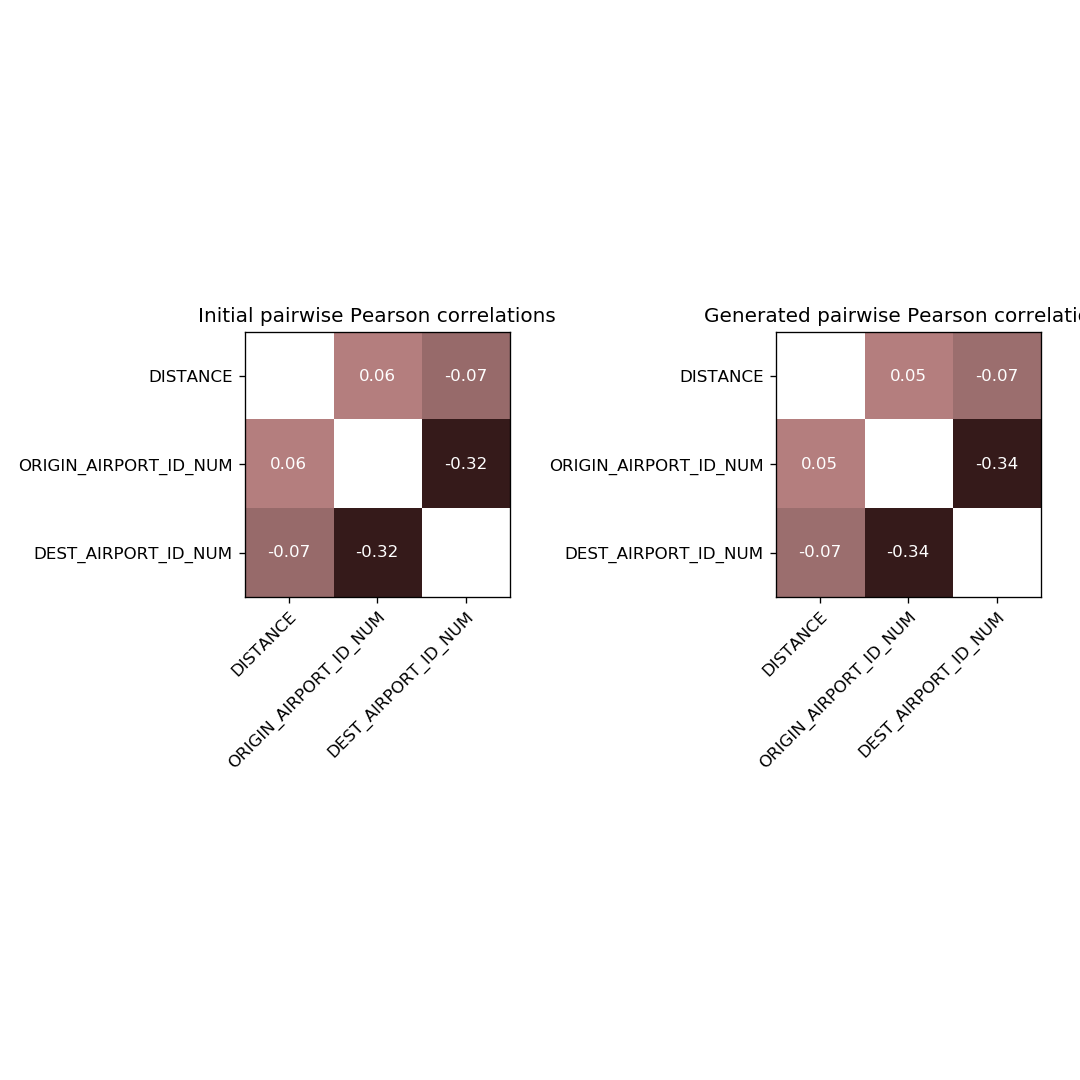

In [65]:
res.pearson_plot()

<IPython.core.display.Javascript object>


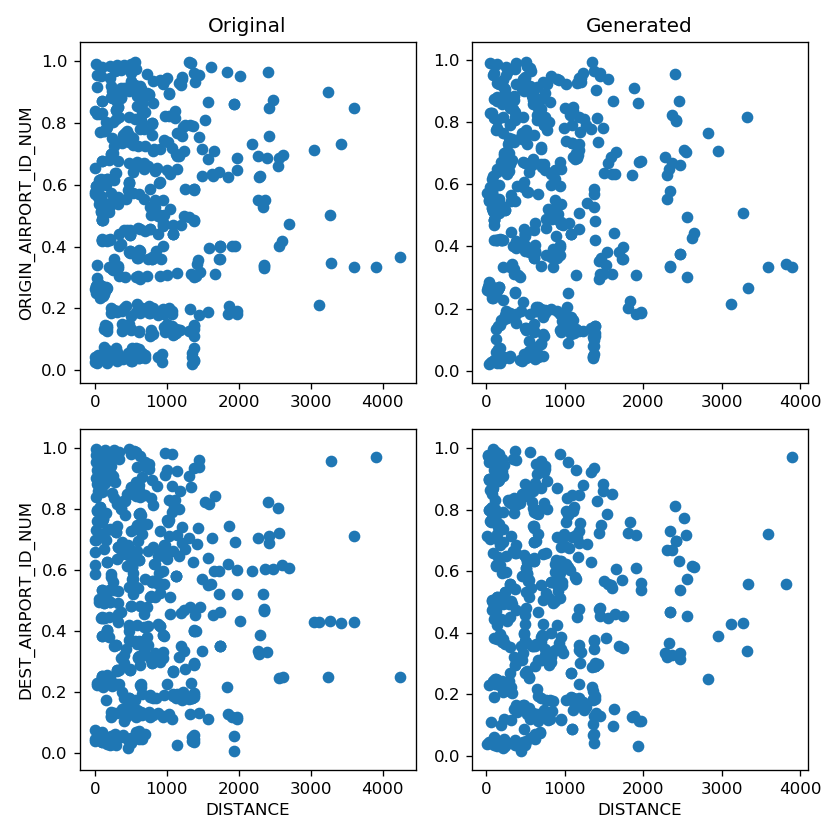

In [66]:
res.variables_scatter_plot()

/home/auriane/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


<IPython.core.display.Javascript object>


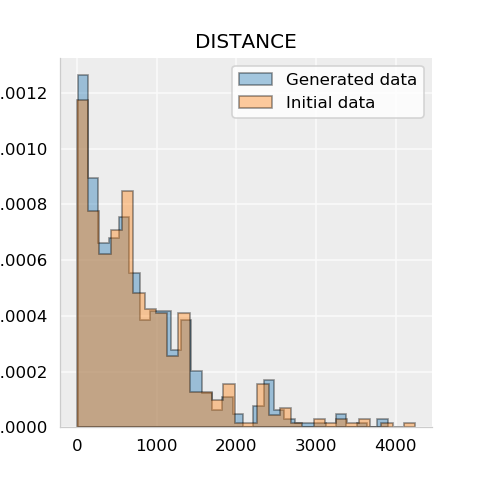

<IPython.core.display.Javascript object>


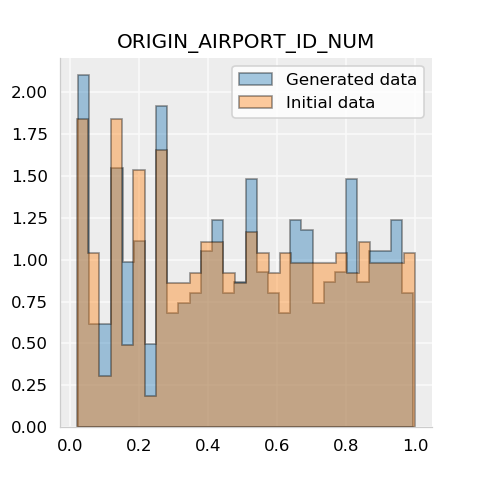

<IPython.core.display.Javascript object>


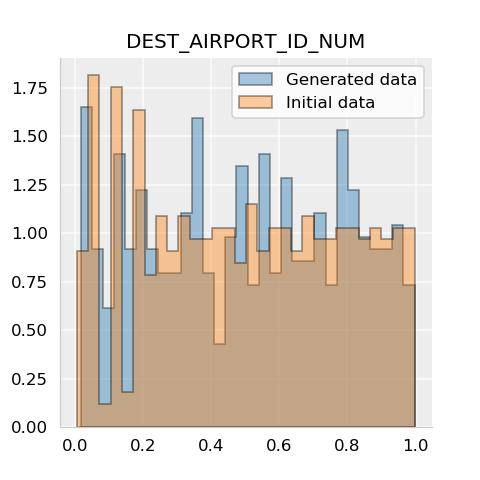

In [67]:
res.compare_distributions()